# Identification of Bus Numbers from Images

### Steps
1. Find bounding box of bus numbers
2. Crop image to bounding box location
3. OCR on cropped image
4. Text to Speech to tell the visually impaired about the bus

In [1]:
# Libaries
import requests, json, numpy as np, time, sys
import azure.cognitiveservices.speech as speechsdk
from PIL import Image
from matplotlib.pyplot import imshow
from dotenv import load_dotenv
from os import getenv

# Global Variables
test_image = "test_img/bus_ext_1.jpeg"

# Preliminary Code
load_dotenv()
%matplotlib inline
!ls

Azure_Functions_API   formatted_data		   test_img
bus_number.wav	      packages-microsoft-prod.deb  test.json
bus_project.ipynb     raw_data			   test_prediction_api.sh
custom_vision_docker  requirements.txt		   YOLOv3
Documents	      run_docker.sh


In [2]:
# Function Run if Unsuccessful

def if_fail():
    print("Unable to determine bus number")
    sys.exit()

## Use Azure Custom Vision to Find Bounding Box of Image

In [16]:
# Use the Custom Vision Docker File (Superior Speed and Cost)
# NOTE: Change the following docker folder if you are using a different docker folder name
! ./custom_vision_docker/run_docker.sh
with open(test_image, 'rb') as image_file:
    custom_vision_response = requests.post("http://127.0.0.1/image", data=image_file, headers={"Content-Type": "application/octet-stream"} )
! docker container kill $(docker ps -q)

Sending build context to Docker daemon  44.15MB
Step 1/7 : FROM python:3.7-slim
 ---> 7e61acc68112
Step 2/7 : RUN pip install -U pip
 ---> Using cache
 ---> ed994d7b27c2
Step 3/7 : RUN pip install numpy==1.17.3 tensorflow==2.0.0 flask pillow
 ---> Using cache
 ---> f84d0c46a18e
Step 4/7 : COPY app /app
 ---> Using cache
 ---> 70389aadb4f0
Step 5/7 : EXPOSE 80
 ---> Using cache
 ---> 8e1924e80b66
Step 6/7 : WORKDIR /app
 ---> Using cache
 ---> fc30363dfc7b
Step 7/7 : CMD python -u app.py
 ---> Using cache
 ---> dfeca480b66b
Successfully built dfeca480b66b
Successfully tagged custom_vision:latest
a2b0ada675f230116c4c4d3e9ea1b9c2288279e9f1b2b3d069a55ca844078eab
a2b0ada675f2


In [4]:
json_response= json.loads(custom_vision_response.text)
bounding_boxes = json_response['predictions']
threshold = 0.2 #Threshold on what probability corresponds to a valid bounding box

# Extract Best Bounding Box with Probability > threshold
max_probability = -1 
for bounding_box in bounding_boxes:
    #print("Box:", bounding_box['probability'])
    max_probability = max(max_probability, bounding_box['probability'])

if max_probability < threshold:
    print("No Valid Bounding Boxes Found")
    if_fail()
for i in bounding_boxes:
    if i['probability'] == max_probability:
        bounding_box = i 
        print(bounding_box)



{'boundingBox': {'height': 0.14775178, 'left': 0.55499666, 'top': 0.31878927, 'width': 0.20148438}, 'probability': 0.50747418, 'tagId': 0, 'tagName': 'bus_number'}


In [5]:
bounding_box = bounding_box['boundingBox']
print("Bounding Box:", bounding_box)

Bounding Box: {'height': 0.14775178, 'left': 0.55499666, 'top': 0.31878927, 'width': 0.20148438}


## Use Python Image Libary to Crop Image at Bounding Box

Image of Bus Number


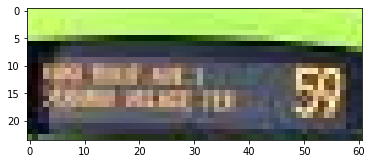

In [6]:
# Import Test Image into Python
raw_image = Image.open(test_image)
width, height = raw_image.size

# Set Points for Cropped Image to Bounding Box
left = width*bounding_box['left']
right = left + width*bounding_box['width']
top = height*bounding_box['top']
bottom = top + height*bounding_box['height']

# Crop Image
bus_num_image = raw_image.crop((left, top, right, bottom))
print("Image of Bus Number")
imshow(np.asarray(bus_num_image)) #Display the Image

OCR Ready Image


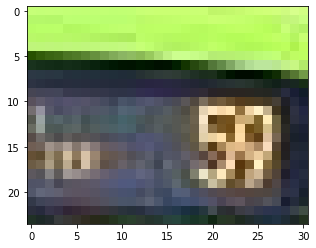

In [7]:
ocr_crop_percentage = 0.5
# Crop Away ocr_crop_percentage of Left Side for OCR Reasons
width, height = bus_num_image.size
left = width * ocr_crop_percentage
right = width
top = 0
bottom = height

ocr_image = bus_num_image.crop((left, top, right, bottom))

# Resize Image with Interpolation if height too big (somehow OCR on Azure doesn't work too well with too sharp of bus numbers)
width, height = ocr_image.size
if height > 50:
    ocr_image = ocr_image.resize((int(width*50/height),50),Image.ANTIALIAS) # Ensure the aspect ratio doesn't change
print("OCR Ready Image")
imshow(np.asarray(ocr_image)) #Display the Image

# Save OCR Ready Image
ocr_image_file = "/tmp/ocr.png"
ocr_image.save(ocr_image_file)

In [8]:
# Fits image into a square of at least 50x50 pixels by padding white space
def Reformat_Image(ImageFilePath):

    from PIL import Image
    image = Image.open(ImageFilePath, 'r')
    image_size = image.size
    width = image_size[0]
    height = image_size[1]

    if(width != height or (width < 50 and height < 50)):
        bigside = width if width > height else height
        if bigside < 50:
            bigside = 50

        background = Image.new('RGBA', (bigside, bigside), (255, 255, 255, 255))
        offset = (int(round(((bigside - width) / 2), 0)), int(round(((bigside - height) / 2),0)))

        background.paste(image, offset)
        background.save(ocr_image_file)
        print("Image has been resized !")
        print(background.size)

    else:
        print("Image is already a square, it has not been resized !")
        
Reformat_Image(ocr_image_file)

Image has been resized !
(50, 50)


## OCR with Azure Cognitive Services

Uses the Recognise Text API which operates asyncronously

In [9]:
# Sending Image file to Recognise Text API
ocr_key = getenv("ocr_key")
ocr_api = "https://southcentralus.api.cognitive.microsoft.com/vision/v2.0/recognizeText"

#ocr_image_file= "helloworld.png"
params ={"mode": "Printed"}
with open(ocr_image_file, 'rb') as image_file:
    print("Sending", ocr_image_file)
    ocr_response = requests.post(ocr_api, data=image_file, headers={"Ocp-Apim-Subscription-Key": ocr_key, "Content-Type": "application/octet-stream"}, params=params )
    print("Resource location", ocr_response.headers['Operation-Location'])
ocr_response

Sending /tmp/ocr.png
Resource location https://southcentralus.api.cognitive.microsoft.com/vision/v2.0/textOperations/34223711-fe5c-4c82-b241-d573db0dfc39


<Response [202]>

In [10]:
# Request for the Result
request_result_api = ocr_response.headers['Operation-Location']

while True:
    ocr_status = requests.get(request_result_api, headers={"Ocp-Apim-Subscription-Key": ocr_key})
    print("Response Text:", ocr_status.text)
    json_response= json.loads(ocr_status.text)
    if json_response['status'] == "Succeeded":
        print("OCR Finished")
        break
    else:
        time.sleep(0.5)

Response Text: {"status":"Succeeded","recognitionResult":{"lines":[{"boundingBox":[12,22,38,22,37,32,12,33],"text":"18 59","words":[{"boundingBox":[11,21,22,21,22,32,11,32],"text":"18","confidence":"Low"},{"boundingBox":[28,21,37,21,37,32,28,32],"text":"59","confidence":"Low"}]}]}}
OCR Finished


In [13]:
# Extract Lines from Response
lines = json_response["recognitionResult"]["lines"]
if len(lines) == 0:
    print("No Text Identified...")

# Finding last word that begins with a number
predicted_number = ""
for line in lines:
    for word in line["words"]:
        #print(word["text"][0])
        if word["text"][0].isdigit():

            predicted_number = word["text"]
            
if predicted_number == "":
    print("Failed to Get a Number...")
    if_fail()
    
else:
    print("Predicted Bus Number:", predicted_number)

Predicted Bus Number: 59


## Synthesise Speech to Output File

In [14]:
speech_key, service_region = ocr_key, "southcentralus"
speech_config = speechsdk.SpeechConfig(subscription=speech_key, region=service_region)

audio_filename = "bus_number.wav"
audio_output = speechsdk.AudioOutputConfig(filename=audio_filename)

speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config, audio_config=audio_output)

text = "Bus "+ predicted_number + " is coming now!"
result = speech_synthesizer.speak_text_async(text).get()

if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
    print("Speech synthesized to [{}] for text [{}]".format(audio_filename, text))
elif result.reason == speechsdk.ResultReason.Canceled:
    cancellation_details = result.cancellation_details
    print("Speech synthesis canceled: {}".format(cancellation_details.reason))
    if cancellation_details.reason == speechsdk.CancellationReason.Error:
        if cancellation_details.error_details:
            print("Error details: {}".format(cancellation_details.error_details))

Speech synthesized to [bus_number.wav] for text [Bus 59 is coming now!]
